# PROBLEM STATEMENT

### IMPORTING LIBRARIES

In [1]:
#Data Manipulation
import pandas as pd
import numpy as np

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#NLP for text pre-processing
import nltk
import scipy
import re
from scipy import spatial
#from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
#tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english') 

# other libraries
import gensim
from gensim.models import Word2Vec
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# remove warnings
import warnings 
warnings.filterwarnings(action = 'ignore') 


C:\Users\adarsha.shivananda\AppData\Roaming\Python\Python37\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from nltk.tokenize import word_tokenize

## Importing data

In [3]:
#Loading the dataset
data=pd.read_csv("flipkart_com-ecommerce_sample.csv")

## Data Exploration

In [4]:
data['description'][1]

"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame for long term durability • Double cushioned Sofa Bed to provide you with extra softness to make a fine seating experience • A double bed that can easily sleep two,Specifications of FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Installation & Demo Installation & Demo Details Installation and demo for this product is done free of cost as part of this purchase. Our service partner will visit your location within 72 business hours from the delivery of the product. In The Box 1 Sofa Bed General Brand FabHomeDecor Mattress Included No Delivery Condition Knock Down Storage Included No Mechanism Type Pull Out Type Sofa Bed Style Contemporary & Modern 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
uniq_id                    20000 non-null object
crawl_timestamp            20000 non-null object
product_url                20000 non-null object
product_name               20000 non-null object
product_category_tree      20000 non-null object
pid                        20000 non-null object
retail_price               19922 non-null float64
discounted_price           19922 non-null float64
image                      19997 non-null object
is_FK_Advantage_product    20000 non-null bool
description                19998 non-null object
product_rating             20000 non-null object
overall_rating             20000 non-null object
brand                      14136 non-null object
product_specifications     19986 non-null object
dtypes: bool(1), float64(2), object(12)
memory usage: 2.2+ MB


In [6]:
data.shape

(20000, 15)

## EDA

### Summary Statistics

In [7]:
#Univariate Analysis
data.describe()

,retail_price,discounted_price
count,19922.000000,19922.000000
mean,2979.206104,1973.401767
std,9009.639341,7333.586040
min,35.000000,35.000000
25%,666.000000,350.000000
50%,1040.000000,550.000000
75%,1999.000000,999.000000
max,571230.000000,571230.000000


In [8]:
#checking the unique values & count for each categorical column
for i in data.columns:
    if data[i].dtype=="object":
        print(i,' ',data[i].describe())
        print('================================')
        print('\n')

uniq_id   count                                20000
unique                               20000
top       6a1db56663bb8de3daea08eb13dd77bc
freq                                     1
Name: uniq_id, dtype: object


crawl_timestamp   count                         20000
unique                          371
top       2015-12-01 12:40:44 +0000
freq                           1979
Name: crawl_timestamp, dtype: object


product_url   count                                                 20000
unique                                                20000
top       http://www.flipkart.com/galloway-skinny-fit-wo...
freq                                                      1
Name: product_url, dtype: object


product_name   count                                          20000
unique                                         12676
top       TheLostPuppy Back Cover for Apple iPad Air
freq                                             134
Name: product_name, dtype: object


product_category_tree   count     

# Observations
1.uniq_id has 19998 different values so we can drop this column.

2.product_url is combination of product name and pid.

3.product_name details are already availble in the description field.        

4.pid has 19998 different values so we can drop this column.

5.retail_price & discounted_price are not useful for our classification because these prices are not constant.

6.image details are not available currently.

7.Most of the observations are not having values for product_rating & overall_rating features.

8.brand has more than 30% null values.so we are droping this field also.

9.description & product_specifications are useful features for our text classification and product_category_tree is the target field.

10.We are considering only "description" as a feature for current work. 

In [9]:
# Adding new column "length" which gives the total length of input variable "Description"
data['length']=data['description'].str.len()

In [10]:
maxlength = data['length'].max()
minlength = data['length'].min()
maxlength,minlength

(5309.0, 74.0)

In [13]:
#Adding New column with no of words in the description before text pre processing
data['no_of_words'] = data.description.apply(lambda x : len(str(x).split()))

### Word count distribution before text cleaning

In [14]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.no_of_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-200', '200-500','500-800' ,'>800'])

In [15]:
words_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'word_counts'})

In [16]:
words_distribution.head()

,bins,word_counts
0,0-100,16141
1,100-200,3497
2,200-500,299
3,500-800,61
4,>800,2


In [20]:
sns.barplot(x='bins', y='word_counts', data=words_distribution).set_title("Word distribution per bin")

# Data Preprocessing

### Handling Missing Values 

In [17]:
# Number of missing values in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'missing'})

# Create a percentage of missing values
missing['percent'] = missing['missing'] / len(data)

# sorting the values in desending order to see highest count on the top
missing.sort_values('percent', ascending = False)

,missing,percent
brand,5864,0.29320
retail_price,78,0.00390
discounted_price,78,0.00390
product_specifications,14,0.00070
image,3,0.00015
length,2,0.00010
description,2,0.00010
uniq_id,0,0.00000
product_rating,0,0.00000
no_of_words,0,0.00000


### Text Preprocessing

In [18]:
# Remove punctuation
data['description'] = data['description'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
data['description'] = data['description'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
data['description'] = data['description'].str.replace(r'^\s+|\s+?$', '')
# converting to lower case
data['description'] = data['description'].str.lower()
data['description'].head()

0    key features of alisha solid women s cycling s...
1    fabhomedecor fabric double sofa bed finish col...
2    key features of aw bellies sandals wedges heel...
3    key features of alisha solid women s cycling s...
4    specifications of sicons all purpose arnica do...
Name: description, dtype: object

In [20]:
# Removing Stop words
stop = stopwords.words('english')
pattern = r'\b(?:{})\b'.format('|'.join(stop))
data['description'] = data['description'].str.replace(pattern, '')
# Removing single characters
data['description'] = data['description'].str.replace(r'\s+', ' ')
data['description'] = data['description'].apply(lambda x: " ".join(x for x in str(x).split() if len(x)>1))

In [24]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [21]:
from nltk.tokenize import word_tokenize

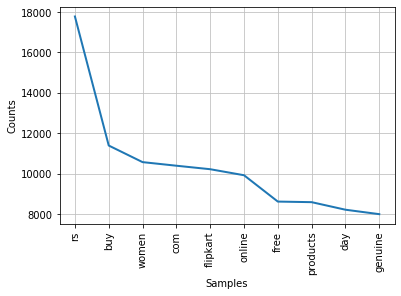

[('rs', 17782), ('buy', 11395), ('women', 10574), ('com', 10396), ('flipkart', 10223), ('online', 9925), ('free', 8621), ('products', 8592), ('day', 8218), ('genuine', 7998)]


In [22]:
# Frequent word list before removing domain related stop words.
a = data['description'].str.cat(sep=' ')
words = a.split()
word_dist = nltk.FreqDist(words)
word_dist.plot(10,cumulative=False)

print(word_dist.most_common(10))

In [23]:
# Removing domain realted stop words from description
specific_stop_words = [ "rs","flipkart","buy","com","free","day","cash","replacement","guarantee","genuine","key","feature","delivery","products","product","shipping", "online","india","shop"]
data['description'] = data['description'].apply(lambda x: " ".join(x for x in x.split() if x not in specific_stop_words))
data['description'].head()

0    features alisha solid women cycling shorts cot...
1    fabhomedecor fabric double sofa bed finish col...
2    features aw bellies sandals wedges heel casual...
3    features alisha solid women cycling shorts cot...
4    specifications sicons purpose arnica dog shamp...
Name: description, dtype: object

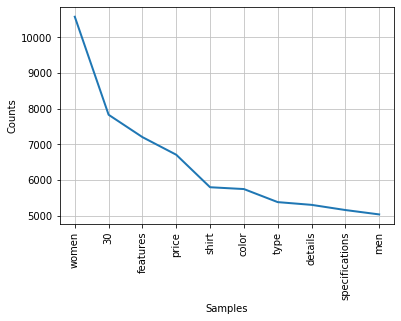

[('women', 10574), ('30', 7826), ('features', 7199), ('price', 6705), ('shirt', 5794), ('color', 5743), ('type', 5377), ('details', 5300), ('specifications', 5155), ('men', 5032)]


In [24]:
#Top frequent words after removing domain related stop words
a = data['description'].str.cat(sep=' ')
words = a.split()
word_dist = nltk.FreqDist(words)
word_dist.plot(10,cumulative=False)
print(word_dist.most_common(10))

## Word count distribution After text preprocessing

In [25]:
data['clean_no_of_words'] = data.description.apply(lambda x : len(x.split()))

In [26]:
data['clean_bins']=pd.cut(data.clean_no_of_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-200', '200-500','500-800' ,'>800'])

In [27]:
clean_words_distribution = data.groupby('clean_bins').size().reset_index().rename(columns={0:'clean_word_counts'})

In [28]:
clean_words_distribution.head()

,clean_bins,clean_word_counts
0,0-100,17724
1,100-200,2178
2,200-500,94
3,500-800,4
4,>800,0


Text(0.5, 1.0, 'Clean Word distribution per bin')

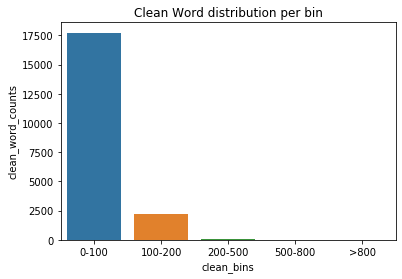

In [29]:
sns.barplot(x='clean_bins', y='clean_word_counts', data=clean_words_distribution).set_title("Clean Word distribution per bin")

## Feature Selection


In [34]:
#We are cosidering only one feature "description" in current work.

# Modelling

## Building recommendation model

In [30]:
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
data['description'] = data['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(data['description'])

tfidf_matrix.shape

(20000, 26163)

In [31]:
#Construct a reverse map of indices and product
indices = pd.Series(data.index, index=data['product_name']).drop_duplicates()
#indices

In [37]:
# Lee Parke Running Shoes

In [32]:
# Function that takes in product title as input and outputs most similar product
def get_recommendations(title):
    # Get the index of the product that matches the description
    idx = indices[title]

    # Get the pairwsie similarity scores of all products with that product
    cosine_sim = linear_kernel(tfidf_matrix[idx], tfidf_matrix)
    sim_scores = list(enumerate(cosine_sim[0]))

    # Sort the product based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar product
    sim_scores = sim_scores[1:10]

    # Get the product indices
    product_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return data['product_name'].iloc[product_indices]

recommended_product = get_recommendations(input("Enter a product name: "))
if recommended_product is not None:
    print ("Similar products")
    print("\n")
    for product_name in recommended_product:
        print (product_name)

Enter a product name: Lee Parke Running Shoes
Similar products


Lee Parke Walking Shoes
N Five Running Shoes
Knight Ace Kraasa Sports Running Shoes, Cycling Shoes, Walking Shoes
WorldWearFootwear Running Shoes, Walking Shoes
reenak Running Shoes
Chazer Running Shoes
Glacier Running Shoes
Sonaxo Men Running Shoes
ETHICS Running Shoes


## Building search model

In [33]:
#Creating list containing description of each product as sublist
fin=[]
for i in range(len(data['description'])):
    temp=[]
    temp.append(data['description'][i])
    fin = fin + temp

data1 = data[['product_name','description']]

In [82]:
from gensim.models import KeyedVectors
filename = 'C:\\Users\\adarsha.shivananda\\Desktop\\Pro\\DS Book\\Book4\\Chapters\\Completed Chapters\\rec sys\\GoogleNews-vectors-negative300.bin\\GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True, limit=50000)

In [72]:
#Preprocessing 

def remove_stopwords(text, is_lower_case=False):
    pattern = r'[^a-zA-z0-9\s]' 
    text = re.sub(pattern, '', text[0])
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [73]:
# Function to get the embedding vector for n dimension, we have used “300”

def get_embedding(word):
    if word in model.wv.vocab:
        return model[x]
    else:
        return np.zeros(300)

In [80]:
#x='product'
# Getting average vector for each document 
out_dict =  {}
for sen in fin:
    average_vector = (np.mean(np.array([get_embedding(x) for x in nltk.word_tokenize(remove_stopwords(sen))]), axis=0))
    dict = { sen : (average_vector) }
    out_dict.update(dict)


In [75]:
# Function to calculate the similarity between the query vector and document vector

def get_sim(query_embedding, average_vector_doc):
    sim = [(1 - scipy.spatial.distance.cosine(query_embedding, average_vector_doc))]
    return sim

In [76]:
# Rank all the documents based on the similarity to get relevant docs

def Ranked_documents(query):
    global rank
    query_words =  (np.mean(np.array([get_embedding(x) for x in nltk.word_tokenize(query.lower())],dtype=float), axis=0))
    rank = []
    for k,v in out_dict.items():
        rank.append((k, get_sim(query_words, v)))
    rank = sorted(rank,key=lambda t: t[1], reverse=True)
    dd =pd.DataFrame(rank,columns=['Desc','score'])
    rankfin = pd.merge(data1,dd,left_on='description',right_on='Desc')
    rankfin = rankfin[['product_name','description','score']]
    print('Ranked Documents :')
    return rankfin

In [77]:
# Call the IR function with a query
query=input("What would you like to search")
Ranked_documents(query)

What would you like to searchbag
Ranked Documents :


,product_name,description,score
0,Alisha Solid Women's Cycling Shorts,key features alisha solid women cycling shorts...,[1.0000000515865854]
1,FabHomeDecor Fabric Double Sofa Bed,fabhomedecor fabric double sofa bed finish col...,[1.0000000515865854]
2,AW Bellies,key features aw bellies sandals wedges heel ca...,[1.0000000515865854]
3,Alisha Solid Women's Cycling Shorts,key features alisha solid women cycling shorts...,[1.0000000515865854]
4,Sicons All Purpose Arnica Dog Shampoo,specifications sicons purpose arnica dog shamp...,[nan]
5,Eternal Gandhi Super Series Crystal Paper Weig...,key features eternal gandhi super series cryst...,[1.0000000515865854]
6,Alisha Solid Women's Cycling Shorts,key features alisha solid women cycling shorts...,[1.0000000515865854]
7,FabHomeDecor Fabric Double Sofa Bed,fabhomedecor fabric double sofa bed finish col...,[1.0000000515865854]
8,"dilli bazaaar Bellies, Corporate Casuals, Casuals",key features dilli bazaaar bellies corporate c...,[1.0000000515865854]
9,Alisha Solid Women's Cycling Shorts,key features alisha solid women cycling shorts...,[1.0000000515865854]
